Number of features in dataset 8
Selected feature indices: [0 1 5 6 7]
10-Fold Cross-Validation Results (After RFE):
Mean MSE: 0.2783
Mean MAE: 0.3507
MSE Standard Deviation: 0.0211
MAE Standard Deviation: 0.0100
Test MSE (After RFE): 0.2951
Test MAE (After RFE): 0.3571


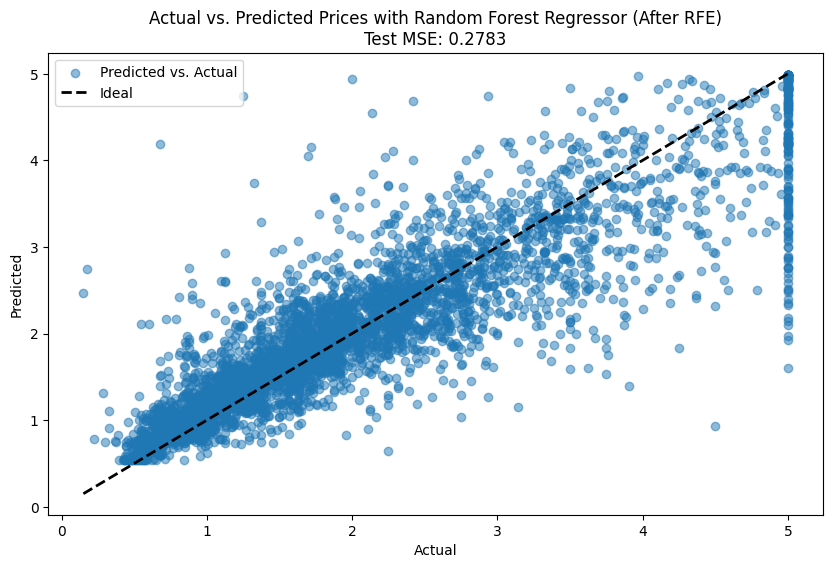

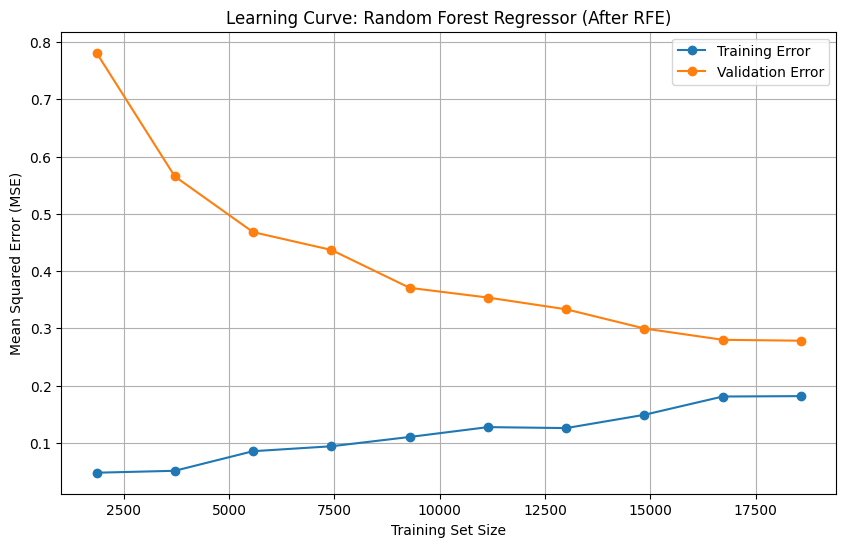

In [ ]:
# Import necessary libraries
from sklearn.model_selection import cross_val_score, KFold, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt

# Load the California housing dataset
X, y = fetch_california_housing(return_X_y=True)

# Split the dataset into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the number of top features to select
print("Number of features in dataset",X.shape[1])
num_features = 5

# Create a base Random Forest model for RFE
base_rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)

# Apply RFE to select the top num_features
rfe = RFE(estimator=base_rf_model, n_features_to_select=num_features)
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = np.where(rfe.support_)[0]
print(f"Selected feature indices: {selected_features}")

# Transform the dataset to only include the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)
X_rfe = rfe.transform(X)

# Create a new Random Forest model to train on the selected features
rf_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)

# 10-Fold Cross-Validation on selected features
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_mse_scores = -cross_val_score(rf_model, X_rfe, y, scoring='neg_mean_squared_error', cv=kf)
cv_mae_scores = -cross_val_score(rf_model, X_rfe, y, scoring='neg_mean_absolute_error', cv=kf)

# Fit the model on the training set with selected features
rf_model.fit(X_train_rfe, y_train)

# Generate predictions on the test set
y_pred = rf_model.predict(X_test_rfe)

# Print the Cross-Validation Results
print("10-Fold Cross-Validation Results (After RFE):")
print(f"Mean MSE: {np.mean(cv_mse_scores):.4f}")
print(f"Mean MAE: {np.mean(cv_mae_scores):.4f}")
print(f"MSE Standard Deviation: {np.std(cv_mse_scores):.4f}")
print(f"MAE Standard Deviation: {np.std(cv_mae_scores):.4f}")

# Evaluate on the test set
test_mse = mean_squared_error(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)
print(f"Test MSE (After RFE): {test_mse:.4f}")
print(f"Test MAE (After RFE): {test_mae:.4f}")

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Prices with Random Forest Regressor (After RFE)\nAverage MSE: {np.mean(cv_mse_scores):.4f}')
plt.legend()
plt.show()

# Generate Learning Curve on selected features
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_rfe, y, cv=kf, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Convert negative MSE scores to positive
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error', marker='o')
plt.plot(train_sizes, test_errors, label='Validation Error', marker='o')
plt.title('Learning Curve: Random Forest Regressor (After RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.show()


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters:
{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
Average MSE across 5 folds (after hyperparameter tuning): 0.2549


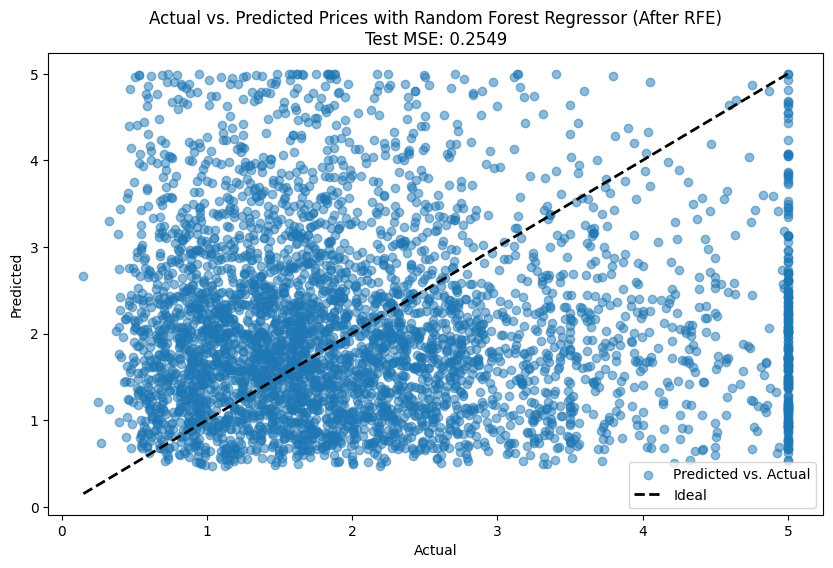

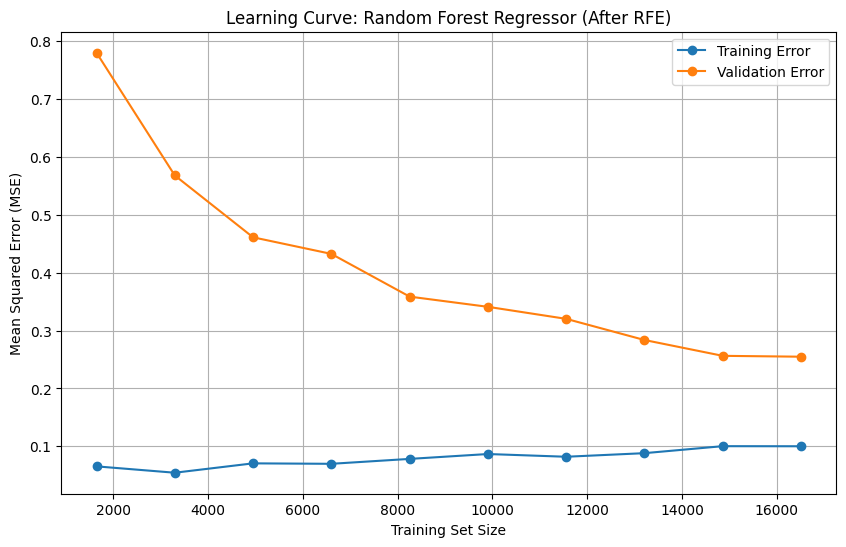

In [ ]:
# Hyperparameter Tuning

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],              # Number of trees in the forest
    'max_depth': [5, 15, None],              # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
#    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
#    'bootstrap': [True, False]               # Whether to bootstrap samples when building trees
}

# Set up GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the reduced dataset
grid_search.fit(X_rfe, y)

# Retrieve the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:")
print(best_params)

# Perform 5-Fold Cross-Validation using the best model
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []

for train_index, test_index in kf.split(X_rfe):
    X_train, X_test = X_rfe[train_index], X_rfe[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the best model
    best_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Calculate and store the MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Report Average MSE with the best model
average_mse = np.mean(mse_scores)
print(f"Average MSE across 5 folds (after hyperparameter tuning): {average_mse:.4f}")

# Generate predictions on the test set
y_pred = best_model.predict(X_test_rfe)

# Plot actual vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Prices with Random Forest Regressor (After RFE)\nTest MSE: {average_mse:.4f}')
plt.legend()
plt.show()

# Generate Learning Curve on selected features
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_rfe, y, cv=kf, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Convert negative MSE scores to positive
train_errors = -train_scores.mean(axis=1)
test_errors = -test_scores.mean(axis=1)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='Training Error', marker='o')
plt.plot(train_sizes, test_errors, label='Validation Error', marker='o')
plt.title('Learning Curve: Random Forest Regressor (After RFE)')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.show()